In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "../data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
SELECTED_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket", "nondom_pocket", "backpack"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2

WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

In [2]:
def load_selected_csvs(base_dir):
    dfs = []

    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(
                    os.path.basename(csv_path)
                )[0]
                dfs.append(df)

    print(
        f"Loaded {len(dfs)} recordings | "
        f"Activities={SELECTED_ACTIVITIES} | "
        f"Positions={SELECTED_POSITIONS}"
    )
    return dfs

In [3]:
def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

In [4]:
def extract_features(window, cols):
    feats = []
    for c in cols:
        x = window[c].values

        feats.extend([
            np.mean(x),
            np.std(x),
            np.min(x),
            np.max(x),
            np.sqrt(np.mean(x ** 2)),
            np.sum(np.abs(x)) / len(x)
        ])

        fft_vals = np.fft.rfft(x)
        fft_mag = np.abs(fft_vals) / len(fft_vals)

        feats.extend([
            np.mean(fft_mag),
            np.std(fft_mag),
            np.max(fft_mag),
            np.sum(fft_mag)
        ])
    return feats

def build_dataset(dfs, feature_cols):
    X, y, groups, positions = [], [], [], []

    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue

        for w in sliding_windows(df):
            X.append(extract_features(w, feature_cols))
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
            positions.append(w["phone_position"].iloc[0])

    return (
        np.array(X),
        np.array(y),
        np.array(groups),
        np.array(positions)
    )

In [5]:
def evaluate_svm(X, y, groups, title):
    outer_cv = GroupKFold(n_splits=5)

    y_true_all, y_pred_all = [], []

    param_grid = {
        "svm__kernel": ["rbf"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", 0.01, 0.001]
    }

    for fold, (train_idx, test_idx) in enumerate(
        outer_cv.split(X, y, groups), 1
    ):
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC())
        ])

        inner_cv = GroupKFold(n_splits=4)

        grid = GridSearchCV(
            pipeline,
            param_grid,
            cv=inner_cv,
            scoring="f1_macro",
            n_jobs=-1
        )

        grid.fit(
            X[train_idx],
            y[train_idx],
            groups=groups[train_idx]
        )

        print(f"\nFold {fold} best params:", grid.best_params_)

        best_model = grid.best_estimator_
        preds = best_model.predict(X[test_idx])

        y_true_all.extend(y[test_idx])
        y_pred_all.extend(preds)

    print(f"\n=== {title} ===")
    print(classification_report(y_true_all, y_pred_all, digits=4))

    cm = confusion_matrix(
        y_true_all,
        y_pred_all,
        labels=SELECTED_ACTIVITIES
    )

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=SELECTED_ACTIVITIES,
        yticklabels=SELECTED_ACTIVITIES,
        cmap="Oranges"
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "precision": precision_score(y_true_all, y_pred_all, average="macro"),
        "recall": recall_score(y_true_all, y_pred_all, average="macro"),
        "f1": f1_score(y_true_all, y_pred_all, average="macro")
    }

Loaded 100 recordings | Activities=['sit', 'walk', 'run', 'stairs'] | Positions=['dom_hand', 'nondom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']

Fold 1 best params: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}

Fold 2 best params: {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}

Fold 3 best params: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

Fold 4 best params: {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}

Fold 5 best params: {'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

=== SVM Raw Device Frame ===
              precision    recall  f1-score   support

         run     0.9984    0.9992    0.9988      1250
         sit     0.9928    0.9960    0.9944      1250
      stairs     0.9425    0.9514    0.9469      1275
        walk     0.9505    0.9376    0.9440      1250

    accuracy                         0.9709      5025
   macro avg     0.9711    0.9710    0.9710      5025
weighted avg     0.9709    0.9709    0.9

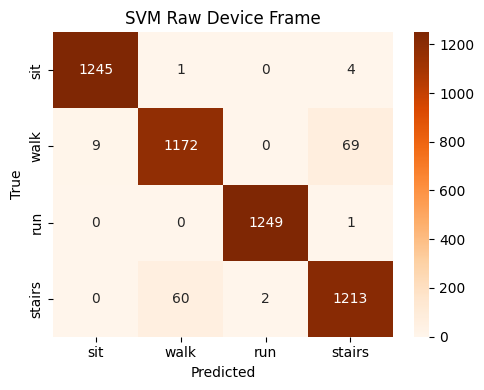


Fold 1 best params: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

Fold 2 best params: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}

Fold 3 best params: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}

Fold 4 best params: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}

Fold 5 best params: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}

=== SVM Global Frame (GFT) ===
              precision    recall  f1-score   support

         run     0.9701    0.9848    0.9774      1250
         sit     0.9879    0.9824    0.9852      1250
      stairs     0.9157    0.8941    0.9048      1275
        walk     0.9062    0.9192    0.9126      1250

    accuracy                         0.9449      5025
   macro avg     0.9450    0.9451    0.9450      5025
weighted avg     0.9448    0.9449    0.9448      5025



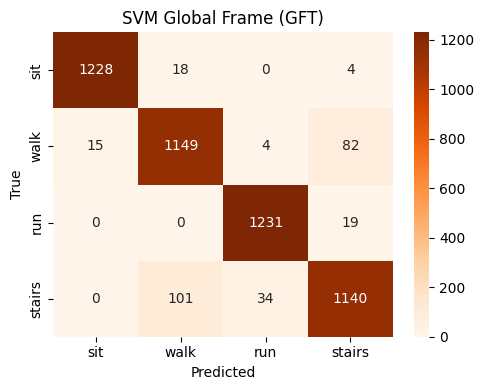


========== SUMMARY ==========
Raw Device Frame: {'precision': 0.9710633393728024, 'recall': 0.971043137254902, 'f1': 0.9710363071138749}
Global Frame (GFT): {'precision': 0.9449504133165081, 'recall': 0.9451294117647059, 'f1': 0.944980348025072}


In [6]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    X_raw, y_raw, g_raw, _ = build_dataset(recordings, RAW_FEATURES)
    raw_metrics = evaluate_svm(
        X_raw, y_raw, g_raw,
        "SVM Raw Device Frame"
    )

    X_gft, y_gft, g_gft, _ = build_dataset(recordings, GFT_FEATURES)
    gft_metrics = evaluate_svm(
        X_gft, y_gft, g_gft,
        "SVM Global Frame (GFT)"
    )

    print("\n========== SUMMARY ==========")
    print("Raw Device Frame:", raw_metrics)
    print("Global Frame (GFT):", gft_metrics)